## XAI mini project- (AIFB dataset) Strategy 2 : Using a XGBOOST Classifier and LIME to explain the predictions

# Setup and Imports

In [86]:
import random
import time
import pandas as pd
import rdflib as rdf
import time
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import lime
import lime.lime_tabular
from rdflib import Graph, URIRef

In [3]:
train_file = 'data/trainingSet.tsv'
test_file = 'data/testSet.tsv'

# Data Loading

In [4]:
# warnings.filterwarnings("ignore")

graph_path = "data/aifbfixed_complete.n3"
graph = rdf.Graph()
graph.parse(graph_path, format="n3")
print("Triples Loaded:", len(graph))

Triples Loaded: 29226


In [5]:

data = {}

for s, p, o in graph:
    if str(s) not in data:
        data[str(s)] = {}
    data[str(s)][p] = str(o)

df = pd.DataFrame.from_dict(data, orient='index')

df = df.fillna('')
df.index = df.index.astype(str)
len(df)

2829

In [6]:
pd.set_option('display.max_rows', 50)

In [7]:
df.columns = df.columns.str.split("/").str[-1]
df.columns = df.columns.str.split("#").str[-1]

df = df.apply(lambda col: col.map(lambda x: x.split("/")[-1]))
df = df.apply(lambda col: col.map(lambda x: x.split("#")[-1]))


In [8]:
df.head()

,month,author,type,pages,number,isAbout,series,year,hasProject,booktitle,...,dealtWithIn,type,journal,howpublished,chapter,type,finances,subClassOf,inverseOf,range
http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id356instance,September,id1876instance,InProceedings,132-147,P-34,id107instance,LNI,2003,id36instance,Proceedings Informatik 2003 - Innovative Infor...,...,,,,,,,,,,
http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id1278instance,September,id2058instance,Book,,,id124instance,,2006,,,...,,,,,,,,,,
http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id1382instance,September,id831instance,Publication,674-683,,,,2006,,Proceedings of Third International Conference ...,...,,,,,,,,,,
http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id1383instance,December,id659instance,Publication,,,id130instance,,2006,id70instance,,...,,,,,,,,,,
http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id387instance,October,id223instance,Publication,89-94,,,,2003,,2nd Workshop on Knowledge Markup and Semantic ...,...,,,,,,,,,,


# Data Exploration

In [11]:
df.columns

Index(['month', 'author', 'type', 'pages', 'number', 'isAbout', 'series',
       'year', 'hasProject', 'booktitle', 'title', 'note', 'address',
       'abstract', 'edition', 'isbn', 'projectInfo', 'member', 'financedBy',
       'homepage', 'carriedOutBy', 'name', 'publication', 'photo', 'phone',
       'affiliation', 'fax', 'worksAtProject', 'publishes', 'carriesOut',
       'employs', 'head', 'volume', 'onProperty', 'allValuesFrom', 'editor',
       'isWorkedOnBy', 'dealtWithIn', 'type', 'journal', 'howpublished',
       'chapter', 'type', 'finances', 'subClassOf', 'inverseOf', 'range'],
      dtype='object')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2829 entries, http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id356instance to http://swrc.ontoware.org/ontology#isWorkedOnBy
Data columns (total 47 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   month           2829 non-null   object
 1   author          2829 non-null   object
 2   type            2829 non-null   object
 3   pages           2829 non-null   object
 4   number          2829 non-null   object
 5   isAbout         2829 non-null   object
 6   series          2829 non-null   object
 7   year            2829 non-null   object
 8   hasProject      2829 non-null   object
 9   booktitle       2829 non-null   object
 10  title           2829 non-null   object
 11  note            2829 non-null   object
 12  address         2829 non-null   object
 13  abstract        2829 non-null   object
 14  edition         2829 non-null   object
 15  isbn            2829 non-

In [103]:
df[df['affiliation'] == 'id1instance']

,month,author,type,pages,number,isAbout,series,year,hasProject,booktitle,...,dealtWithIn,type,journal,howpublished,chapter,type,finances,subClassOf,inverseOf,range
http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id2044instance,,,Person,,,,,,,,...,,,,,,,,,,
http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id2058instance,,,Person,,,,,,,,...,,,,,,,,,,
http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id99instance,,,PhDStudent,,,,,,,,...,,,,,,,,,,
http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id2121instance,,,PhDStudent,,,,,,,,...,,,,,,,,,,
http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id1954instance,,,Person,,,,,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id1920instance,,,Person,,,,,,,,...,,,,,,,,,,
http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id1872instance,,,Person,,,,,,,,...,,,,,,,,,,
http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id1953instance,,,Person,,,,,,,,...,,,,,,,,,,
http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id2069instance,,,Person,,,,,,,,...,,,,,,,,,,


In [96]:
df['affiliation'].value_counts()

affiliation
               2651
id1instance      73
id3instance      60
id2instance      28
id4instance      16
id5instance       1
Name: count, dtype: int64

In [111]:
complete=pd.read_csv('data/completeDataset.tsv', sep='\t',index_col=0)

# Distribution of Reserach groups

C:\Users\viraj\AppData\Local\Temp\ipykernel_12616\116418882.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


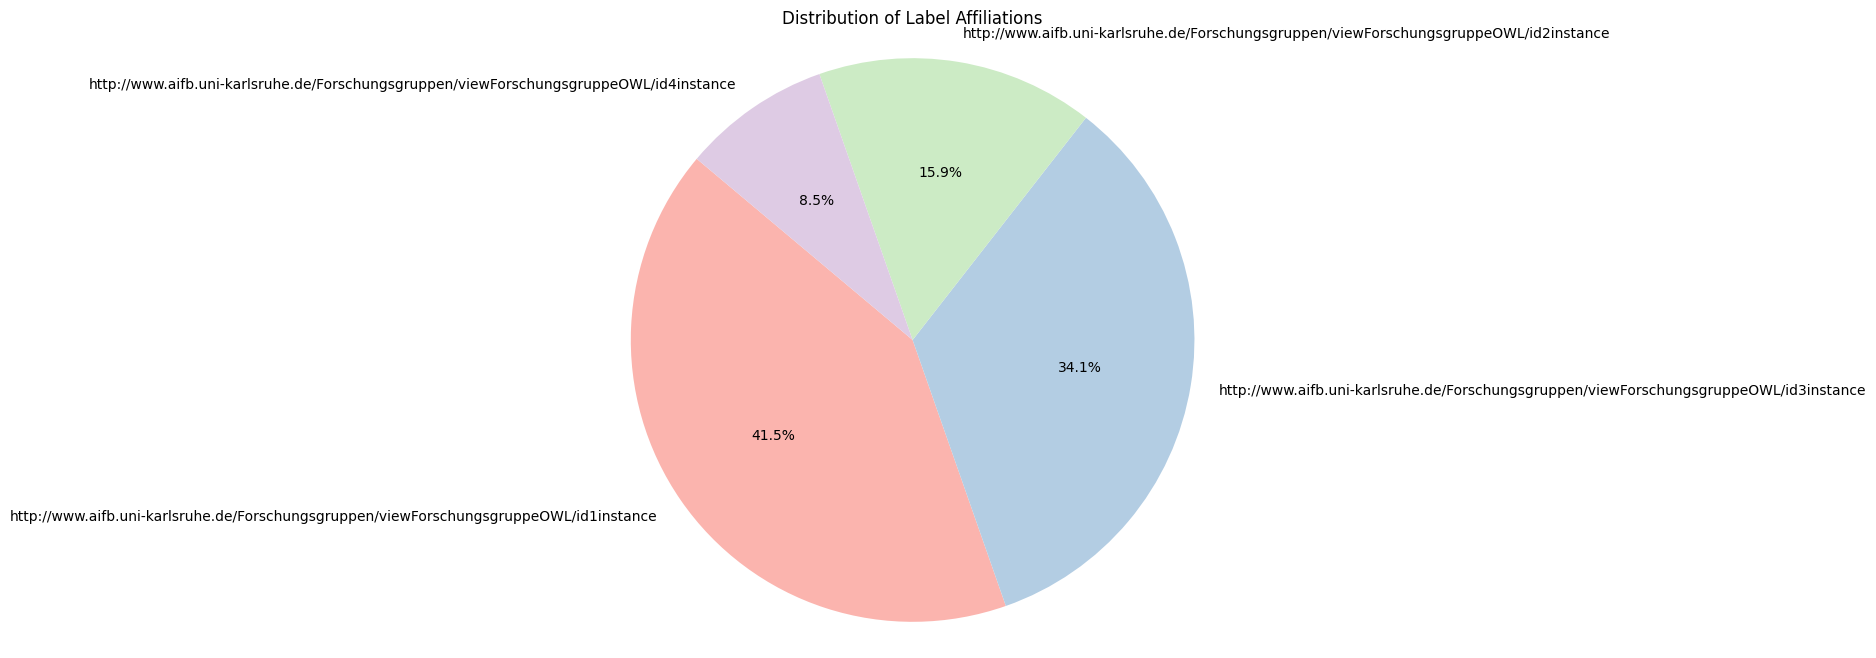

In [ ]:
import matplotlib.pyplot as plt

#  occurrences of each label
label_counts = complete['label_affiliation'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%',
        startangle=140, colors=plt.cm.Pastel1.colors)

plt.title('Distribution of Label Affiliations')
plt.axis('equal')  
plt.tight_layout()
plt.show()

As we only need the persons data, we validated by only selecting persons from train and test files.

# Feature Selection using Variance threshold

In [ ]:
train_labels_df = pd.read_csv("data/trainingSet.tsv", sep="\t")
test_labels_df = pd.read_csv("data/testSet.tsv", sep="\t")

#only valid persons
train_labels_df['person'] = train_labels_df['person'].astype(str).str.strip()
test_labels_df['person'] = test_labels_df['person'].astype(str).str.strip()


df.index = df.index.astype(str).str.strip()

#to encode the dataframe
df_encoded = pd.get_dummies(df)

train_matches = df_encoded.index.intersection(train_labels_df['person'])
test_matches = df_encoded.index.intersection(test_labels_df['person'])

print(f"Matched training persons: {len(train_matches)}")
print(f"Matched testing persons: {len(test_matches)}")

# x labels
X_train = df_encoded.loc[train_matches]
X_test = df_encoded.loc[test_matches]

# y labels
y_train = train_labels_df.set_index('person').loc[train_matches]['label_affiliation']
y_test = test_labels_df.set_index('person').loc[test_matches]['label_affiliation']


print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Matched training persons: 140
Matched testing persons: 36
X_train shape: (140, 6879)
X_test shape: (36, 6879)
y_train shape: (140,)
y_test shape: (36,)


In [70]:
person_names_test = X_test.index.tolist()

In [71]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.001)
X_train_selected = selector.fit_transform(X_train)
X_test_selected = selector.transform(X_test)

# initially selected feature names
initial_feature_names = df_encoded.columns[selector.get_support(indices=True)]

# features to exclude manually
excluded_features = {
    'affiliation_id1instance',
    'affiliation_id2instance',
    'affiliation_id3instance',
    'affiliation_id4instance'
}


filtered_feature_names = [f for f in initial_feature_names if f not in excluded_features]

filtered_indices = [list(initial_feature_names).index(f) for f in filtered_feature_names]

X_train_filtered = X_train_selected[:, filtered_indices]
X_test_filtered = X_test_selected[:, filtered_indices]

X_train_np = X_train_filtered.astype(float)
X_test_np = X_test_filtered.astype(float)

print("X_train shape before selection:", X_train.shape)
print("X_train shape after selection:", X_train_selected.shape)
print("X_train shape after manual filtering:", X_train_np.shape)
print("Number of selected features after filtering:", len(filtered_feature_names))


X_train shape before selection: (140, 6879)
X_train shape after selection: (140, 486)
X_train shape after manual filtering: (140, 482)
Number of selected features after filtering: 482


We Excluded 
'affiliation_id1instance',
'affiliation_id2instance',
'affiliation_id3instance',
'affiliation_id4instance'

from X set as it caused data leakage while splitting the data for train and test


In [23]:
initial_feature_names.to_list()

['type_AssistantProfessor',
 'type_FullProfessor',
 'type_Person',
 'type_PhDStudent',
 'homepage_',
 'homepage_3.html',
 'homepage_A STEP TOWARDS AN INTEGRATED PRODUCT INFORMATION MANAGEMENT',
 'homepage_DesktopDefault.aspx?tabID=20&showPage=StaffProfile&editId=313&editModuleID=50&editShowMenu=true&lang=de',
 'homepage_GuS',
 'homepage_None',
 'homepage_aeb',
 'homepage_denny.vrandecic.de',
 'homepage_index.htm',
 'homepage_index.html',
 'homepage_indexde.html',
 'homepage_landes.htm',
 'homepage_maedche.html',
 'homepage_michael.guntsch.de',
 'homepage_mitarbeiter.php?id=485',
 'homepage_mitarbeiter.php?id=77',
 'homepage_mkl.html',
 'homepage_phi',
 'homepage_rku',
 'homepage_rvo',
 'homepage_schmitz',
 'homepage_web',
 'homepage_www.Xam.de',
 'homepage_www.matze-bonn.de',
 'homepage_ysu',
 'homepage_~jbr',
 'homepage_~mer',
 'name_Agnes Koschmider',
 'name_Aleksander Pivk',
 'name_Alexander Maedche',
 'name_Amir Safari',
 'name_Andreas Eberhart',
 'name_Andreas Frick',
 'name_Andre

In [24]:
filtered_feature_names

['type_AssistantProfessor',
 'type_FullProfessor',
 'type_Person',
 'type_PhDStudent',
 'homepage_',
 'homepage_3.html',
 'homepage_A STEP TOWARDS AN INTEGRATED PRODUCT INFORMATION MANAGEMENT',
 'homepage_DesktopDefault.aspx?tabID=20&showPage=StaffProfile&editId=313&editModuleID=50&editShowMenu=true&lang=de',
 'homepage_GuS',
 'homepage_None',
 'homepage_aeb',
 'homepage_denny.vrandecic.de',
 'homepage_index.htm',
 'homepage_index.html',
 'homepage_indexde.html',
 'homepage_landes.htm',
 'homepage_maedche.html',
 'homepage_michael.guntsch.de',
 'homepage_mitarbeiter.php?id=485',
 'homepage_mitarbeiter.php?id=77',
 'homepage_mkl.html',
 'homepage_phi',
 'homepage_rku',
 'homepage_rvo',
 'homepage_schmitz',
 'homepage_web',
 'homepage_www.Xam.de',
 'homepage_www.matze-bonn.de',
 'homepage_ysu',
 'homepage_~jbr',
 'homepage_~mer',
 'name_Agnes Koschmider',
 'name_Aleksander Pivk',
 'name_Alexander Maedche',
 'name_Amir Safari',
 'name_Andreas Eberhart',
 'name_Andreas Frick',
 'name_Andre

# Label Encoding and model training using XGBOOST classifier

In [72]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)


In [126]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

model = XGBClassifier(
    # use_label_encoder=True, 
    # eval_metric='mlogloss',
    
    # random_state=42
    objective='multi:softprob',
    eval_metric='mlogloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False
)
model.fit(X_train_np, y_train_enc)



c:\Users\viraj\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [04:27:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

# Prediction and Model Evaluation


In [128]:
y_pred = model.predict(X_test_np)
accuracy = accuracy_score(y_test_enc, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test_enc, y_pred, target_names=encoder.classes_))


Test Accuracy: 0.7778
Classification Report:
                                                                                        precision    recall  f1-score   support

http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id1instance       1.00      0.87      0.93        15
http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id2instance       0.50      0.17      0.25         6
http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id3instance       0.71      1.00      0.83        12
http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id4instance       0.50      0.67      0.57         3

                                                                              accuracy                           0.78        36
                                                                             macro avg       0.68      0.67      0.64        36
                                                         

In [129]:
train_preds = model.predict(X_train_np)
train_acc = accuracy_score(y_train_enc, train_preds)
print(f"Training accuracy: {train_acc:.4f}")

test_preds = model.predict(X_test_np)
test_acc = accuracy_score(y_test_enc, test_preds)
print(f"Testing accuracy: {test_acc:.4f}")


Training accuracy: 0.8643
Testing accuracy: 0.7778


In [130]:
#the actual names of the instances
label_map = {
    'id1instance': ' Business Information and Communication Systems',
    'id2instance': 'Efficient Algorithms',
    'id3instance': ' Knowledge Management',
    'id4instance': 'Complexity Management'
}

readable_class_names = [label_map.get(label.split('/')[-1], label) for label in encoder.classes_]


In [56]:
readable_class_names

[' Business Information and Communication Systems',
 'Efficient Algorithms',
 ' Knowledge Management',
 'Complexity Management']

# Explaining the predictions using LIME Explainer 

In [92]:


#LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=filtered_feature_names,
    class_names=readable_class_names,
    mode='classification',
    discretize_continuous=True
)



instance_index = 2
instance = X_test_np[instance_index]

person_name = person_names_test[instance_index]

probs = model.predict_proba([instance])[0]
pred_class_idx = np.argmax(probs)
pred_class_name = readable_class_names[pred_class_idx]
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=model.predict_proba,
    num_features=10
)

#printing explainer
exp.show_in_notebook(show_table=True)


name_predicate = URIRef("http://swrc.ontoware.org/ontology#name")

person_uri = URIRef(person_names_test[instance_index])

person_name = str(person_uri)

# Default to the URI if name isn't found
for _, _, o in graph.triples((person_uri, name_predicate, None)):
    person_name = str(o)


print(f"\nExplaining prediction for test instance #{person_name,person_uri,}")
print(f"Predicted class: {pred_class_name} (probability: {probs[pred_class_idx]:.2f})")
print("Top features influencing prediction:")
for feature, weight in exp.as_list():
    print(f"{feature:60s} | weight: {weight:.4f}")



Explaining prediction for test instance #('Daniel Ried', rdflib.term.URIRef('http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id2121instance'))
Predicted class:  Business Information and Communication Systems (probability: 0.88)
Top features influencing prediction:
worksAtProject_id63instance > 0.00                           | weight: 0.2952
fax_+49 (721) 608 4548 > 0.00                                | weight: -0.2137
worksAtProject_ <= 0.00                                      | weight: 0.2021
0.00 < homepage_ <= 1.00                                     | weight: 0.1773
homepage_None <= 0.00                                        | weight: 0.1577
fax_+49 (721) 608 6580 <= 0.00                               | weight: 0.1538
fax_+49 (721) 608 5998 <= 0.00                               | weight: 0.1380
phone_+49 (721) 608 7362 <= 0.00                             | weight: 0.1232
fax_ <= 0.00                                                 | weight: 0.1161
photo_ <= 0.00         

# Train and test distributions

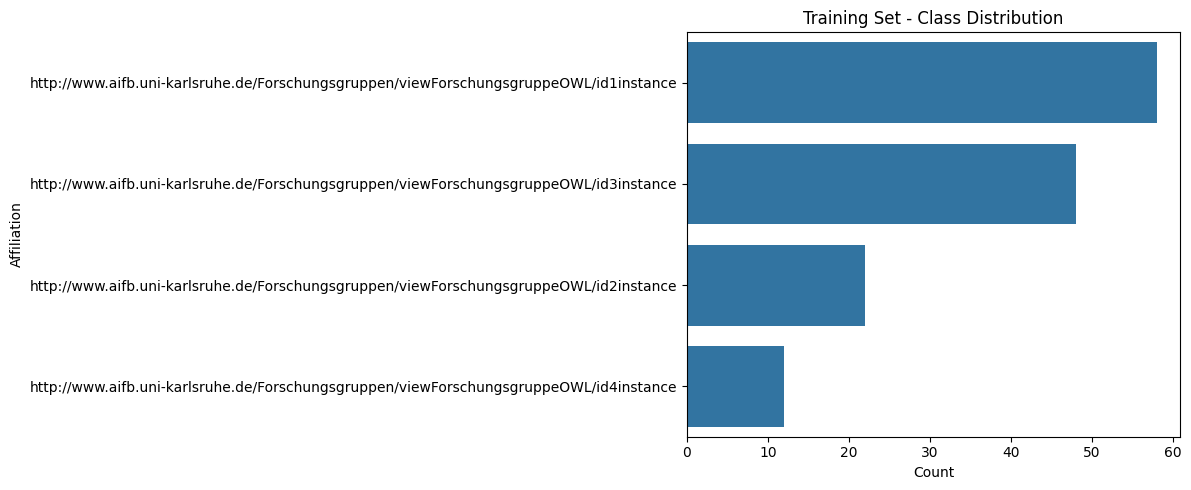

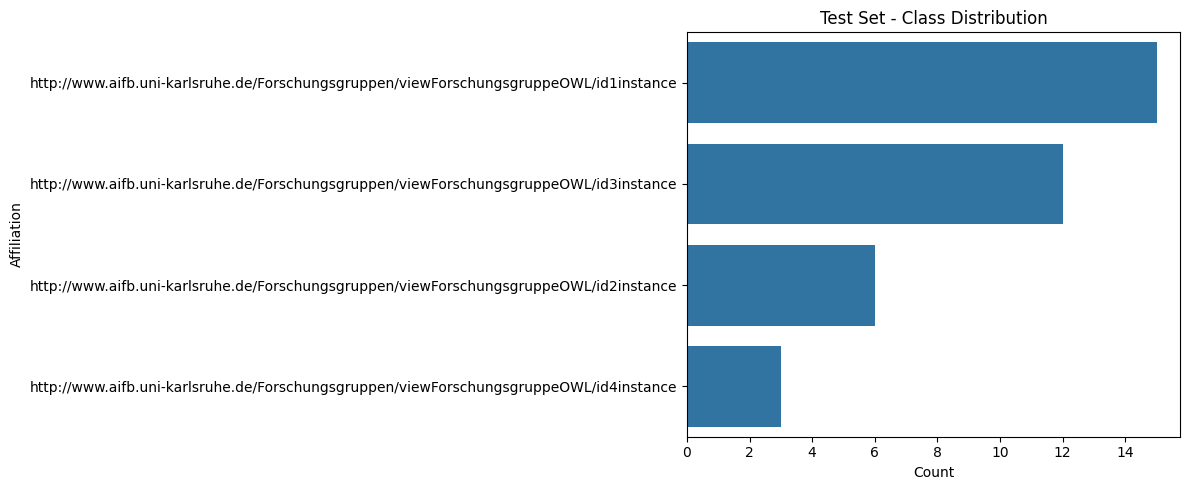

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert encoded labels back to readable
y_train_labels = encoder.inverse_transform(y_train_enc)
y_test_labels = encoder.inverse_transform(y_test_enc)

# Plot train and test distribution
plt.figure(figsize=(12, 5))
sns.countplot(y=y_train_labels, order=pd.Series(y_train_labels).value_counts().index)
plt.title("Training Set - Class Distribution")
plt.xlabel("Count")
plt.ylabel("Affiliation")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.countplot(y=y_test_labels, order=pd.Series(y_test_labels).value_counts().index)
plt.title("Test Set - Class Distribution")
plt.xlabel("Count")
plt.ylabel("Affiliation")
plt.tight_layout()
plt.show()


# Feature importance

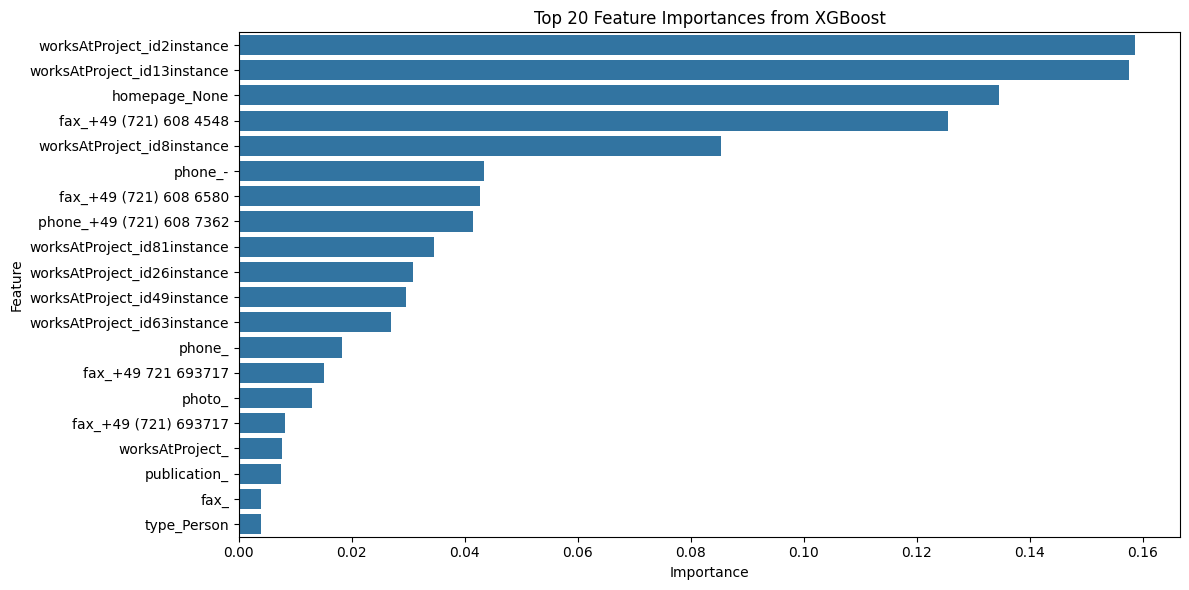

In [33]:
importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': filtered_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# top 20 features
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature')
plt.title("Top 20 Feature Importances from XGBoost")
plt.tight_layout()
plt.show()
